# Barrier certificates for collision avoidance

**Adapted from**: Example 2 of "Engineering applications of SOS polynomials" by Georgina Hall, from
the 2019 AMS Short Course on Sum of Squares: Theory and Applications
Implementation by: Hugo Tadashi Kussaba

In [1]:
using DynamicPolynomials
@polyvar x[1:2]

using SumOfSquares
using CSDP

We need to pick an SDP solver, see [here](https://jump.dev/JuMP.jl/v1.12/installation/#Supported-solvers) for a list of the available choices.
We use `SOSModel` instead of `Model` to be able to use the `>=` syntax for Sum-of-Squares constraints.

In [2]:
solver = optimizer_with_attributes(CSDP.Optimizer, MOI.Silent() => true)
model = SOSModel(solver);

We define below the vector field $\text{d}x/\text{d}t = f$

In [3]:
f = [ x[2],
     -x[1] + (1/3)*x[1]^3 - x[2]]

2-element Vector{DynamicPolynomials.Polynomial{DynamicPolynomials.Commutative{DynamicPolynomials.CreationOrder}, MultivariatePolynomials.Graded{MultivariatePolynomials.LexOrder}, Float64}}:
 x₂
 -x₂ - x₁ + 0.3333333333333333x₁³

Semi-algebraic function describing the unsafe set 𝒳ᵤ

In [4]:
g₁ = -(x[1]+1)^2 - (x[2]+1)^2 + 0.16  # 𝒳ᵤ = {x ∈ R²: g₁(x) ≥ 0}

-1.84 - 2.0x₂ - 2.0x₁ - x₂² - x₁²

Semi-algebraic function describing the initial set 𝒳₀

In [5]:
h₁ = -(x[1]-1.5)^2 - x[2]^2 + 0.25    # 𝒳₀ = {x ∈ R²: h₁(x) ≥ 0}

-2.0 + 3.0x₁ - x₂² - x₁²

Define SOS barrier function B

In [6]:
monos = monomials(x, 0:4)
@variable(model, B, Poly(monos))

(_[1]) + (_[2])x₂ + (_[3])x₁ + (_[4])x₂² + (_[5])x₁x₂ + (_[6])x₁² + (_[7])x₂³ + (_[8])x₁x₂² + (_[9])x₁²x₂ + (_[10])x₁³ + (_[11])x₂⁴ + (_[12])x₁x₂³ + (_[13])x₁²x₂² + (_[14])x₁³x₂ + (_[15])x₁⁴

Define barrier certificate constraints using SOS relaxation

B(x) > 0 for all x ∈ 𝒳ᵤ

In [7]:
ε = 0.001
@constraint(model, B >= ε, domain = @set(g₁ >= 0))

(_[1] - 0.001) + (_[2])x₂ + (_[3])x₁ + (_[4])x₂² + (_[5])x₁x₂ + (_[6])x₁² + (_[7])x₂³ + (_[8])x₁x₂² + (_[9])x₁²x₂ + (_[10])x₁³ + (_[11])x₂⁴ + (_[12])x₁x₂³ + (_[13])x₁²x₂² + (_[14])x₁³x₂ + (_[15])x₁⁴ is SOS

B(x) ≤ 0 for all x ∈ 𝒳₀

In [8]:
@constraint(model, B <= 0, domain = @set(h₁ >= 0))

(-_[1]) + (-_[2])x₂ + (-_[3])x₁ + (-_[4])x₂² + (-_[5])x₁x₂ + (-_[6])x₁² + (-_[7])x₂³ + (-_[8])x₁x₂² + (-_[9])x₁²x₂ + (-_[10])x₁³ + (-_[11])x₂⁴ + (-_[12])x₁x₂³ + (-_[13])x₁²x₂² + (-_[14])x₁³x₂ + (-_[15])x₁⁴ is SOS

Ḃ(x) ≤ 0 for all x ∈ R²

In [9]:
using LinearAlgebra # Needed for `dot`
dBdt = dot(differentiate(B, x), f)
@constraint(model, -dBdt >= 0)

(_[2] - _[3])x₂ + (_[2])x₁ + (2 _[4] - _[5])x₂² + (2 _[4] + _[5] - 2 _[6])x₁x₂ + (_[5])x₁² + (3 _[7] - _[8])x₂³ + (3 _[7] + 2 _[8] - 2 _[9])x₁x₂² + (2 _[8] + _[9] - 3 _[10])x₁²x₂ + (-0.3333333333333333 _[2] + _[9])x₁³ + (4 _[11] - _[12])x₂⁴ + (4 _[11] + 3 _[12] - 2 _[13])x₁x₂³ + (3 _[12] + 2 _[13] - 3 _[14])x₁²x₂² + (-0.6666666666666666 _[4] + 2 _[13] + _[14] - 4 _[15])x₁³x₂ + (-0.3333333333333333 _[5] + _[14])x₁⁴ + (-_[7])x₁³x₂² + (-0.6666666666666666 _[8])x₁⁴x₂ + (-0.3333333333333333 _[9])x₁⁵ + (-1.3333333333333333 _[11])x₁³x₂³ + (-_[12])x₁⁴x₂² + (-0.6666666666666666 _[13])x₁⁵x₂ + (-0.3333333333333333 _[14])x₁⁶ is SOS

The model is ready to be optimized by the solver:

In [10]:
JuMP.optimize!(model)

We verify that the solver has found a feasible solution:

In [11]:
JuMP.primal_status(model)

FEASIBLE_POINT::ResultStatusCode = 1

Plot the phase plot with the 0-level set of the barrier function, and the boundary of the initial and unsafe sets

┌ Warning: To maintain consistency with solution indexing, keyword argument vars will be removed in a future version. Please use keyword argument idxs instead.
│   caller = ip:0x0
└ @ Core :-1
┌ Warning: Interrupted. Larger maxiters is needed. If you are using an integrator for non-stiff ODEs or an automatic switching algorithm (the default), you may want to consider using a method for stiff equations. See the solver pages for more details (e.g. https://docs.sciml.ai/DiffEqDocs/stable/solvers/ode_solve/#Stiff-Problems).
└ @ SciMLBase ~/.julia/packages/SciMLBase/hSv8d/src/integrator_interface.jl:597


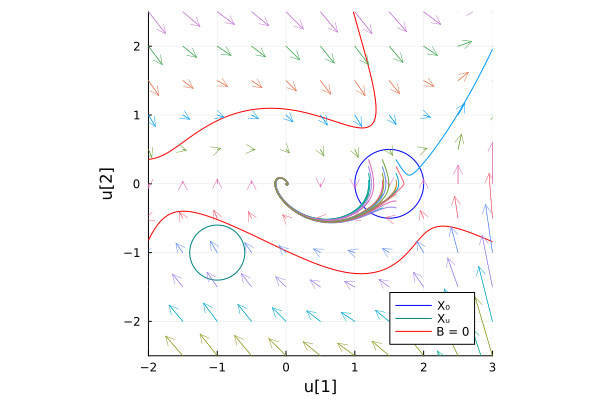

In [12]:
import DifferentialEquations, Plots, ImplicitPlots
function phase_plot(f, B, g₁, h₁, quiver_scaling, Δt, X0, solver = DifferentialEquations.Tsit5())
    X₀plot = ImplicitPlots.implicit_plot(h₁; xlims=(-2, 3), ylims=(-2.5, 2.5), resolution = 1000, label="X₀", linecolor=:blue)
    Xᵤplot = ImplicitPlots.implicit_plot!(g₁; xlims=(-2, 3), ylims=(-2.5, 2.5), resolution = 1000, label="Xᵤ", linecolor=:teal)
    Bplot  = ImplicitPlots.implicit_plot!(B; xlims=(-2, 3), ylims=(-2.5, 2.5), resolution = 1000, label="B = 0", linecolor=:red)
    Plots.plot(X₀plot)
    Plots.plot!(Xᵤplot)
    Plots.plot!(Bplot)
    ∇(vx, vy) = [fi(x[1] => vx, x[2] => vy) for fi in f]
    ∇pt(v, p, t) = ∇(v[1], v[2])
    function traj(v0)
        tspan = (0.0, Δt)
        prob = DifferentialEquations.ODEProblem(∇pt, v0, tspan)
        return DifferentialEquations.solve(prob, solver, reltol=1e-8, abstol=1e-8)
    end
    ticks = -5:0.5:5
    X = repeat(ticks, 1, length(ticks))
    Y = X'
    Plots.quiver!(X, Y, quiver = (x, y) -> ∇(x, y) / quiver_scaling, linewidth=0.5)
    for x0 in X0
        Plots.plot!(traj(x0), vars=(1, 2), label = nothing)
    end
    Plots.plot!(xlims = (-2, 3), ylims = (-2.5, 2.5))
end

phase_plot(f, value(B), g₁, h₁, 10, 30.0, [[x1, x2] for x1 in 1.2:0.2:1.7, x2 in -0.35:0.1:0.35])

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*